In [1]:
from transformers import AutoModelForCausalLM
import torch

In [3]:
llama3 = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B")
llama3.to("cuda")
llama3

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(f'meta-llama/Meta-Llama-3-8B', use_fast=True, trust_remote_code=True)
tokenizer

In [4]:
from hellaswag import render_example, iterate_examples
from torch.nn import functional as F

In [5]:
val = list(enumerate(iterate_examples("val")))
len(val)

10042

In [7]:
def get_most_likely_row(tokens, mask, logits):
    # evaluate the autoregressive loss at all positions
    shift_logits = (logits[..., :-1, :]).contiguous()
    shift_tokens = (tokens[..., 1:]).contiguous()
    flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    flat_shift_tokens = shift_tokens.view(-1)
    shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
    shift_losses = shift_losses.view(tokens.size(0), -1)
    # now get the average loss just for the completion region (where mask == 1), in each row
    shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
    masked_shift_losses = shift_losses * shift_mask
    # sum and divide by the number of 1s in the mask
    sum_loss = masked_shift_losses.sum(dim=1)
    avg_loss = sum_loss / shift_mask.sum(dim=1)
    # now we have a loss for each of the 4 completions
    # the one with the lowest loss should be the most likely
    pred_norm = avg_loss.argmin().item()
    return pred_norm

In [9]:
from tqdm import tqdm

num_total = 0
num_correct_norm = 0

# 创建一个进度条
for i, example in tqdm(val, desc="Processing", unit="example"):
    # only process examples where i % ddp_world_size == ddp_rank
    # render the example into tokens and labels
    _, tokens, mask, label = render_example(example)
    tokens = tokens.to("cuda:2")
    mask = mask.to("cuda:2")
    # get the logits
    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits = llama3(tokens).logits
        pred_norm = get_most_likely_row(tokens, mask, logits)
    num_total += 1
    num_correct_norm += int(pred_norm == label)
acc_norm = num_correct_norm / num_total
print(f"HellaSwag accuracy: {num_correct_norm}/{num_total}={acc_norm:.4f}")

Processing: 100%|██████████| 10042/10042 [14:00<00:00, 11.95example/s]

HellaSwag accuracy: 7039/10042=0.7010


In [1]:
from dataclasses import dataclass
from typing import Optional, Tuple

@dataclass
class ModelArgs:
    dim: int = 768
    intermediate_size: int = 14336
    n_layers: int = 12
    n_heads: int = 12
    n_kv_heads: int = 12
    vocab_size: int = 50257
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5
    rope_theta: int = 500000

    max_batch_size: int = 32
    max_seq_len: int = 1024

In [2]:
import os
import math
import time
import inspect
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
import torch.nn as nn
from torch.nn import functional as F
from hellaswag import render_example, iterate_examples

class LlamaRMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        LlamaRMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)

class LlamaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None, scaling_factor=1.0):
        super().__init__()
        self.scaling_factor = scaling_factor
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        # For BC we register cos and sin cached
        self.max_seq_len_cached = max_position_embeddings

    @torch.no_grad()
    def forward(self, x, position_ids):
        # x: [bs, num_attention_heads, seq_len, head_size]
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()
        # Force float32 since bfloat16 loses precision on long contexts
        # See https://github.com/huggingface/transformers/pull/29285
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            cos = emb.cos()
            sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


class LlamaAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config: ModelArgs, layer_idx: Optional[int] = None):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx

        self.hidden_size = config.dim
        self.num_heads = config.n_heads
        self.head_dim = self.hidden_size // self.num_heads
        self.num_key_value_heads = config.n_kv_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.max_position_embeddings = config.max_seq_len
        self.rope_theta = config.rope_theta
        self.is_causal = True

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self._init_rope()

    def _init_rope(self):
        self.rotary_emb = LlamaRotaryEmbedding(
            self.head_dim,
            max_position_embeddings=self.max_position_embeddings,
            base=self.rope_theta,
        )

    # Adapted from LlamaAttention.forward
    def forward(
        self,
        hidden_states: torch.Tensor,
        position_ids: Optional[torch.LongTensor] = None,
    ) -> torch.Tensor:
        bsz, q_len, _ = hidden_states.size()

        query_states = self.q_proj(hidden_states)
        key_states = self.k_proj(hidden_states)
        value_states = self.v_proj(hidden_states)

        query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        cos, sin = self.rotary_emb(value_states, position_ids)
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        
        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)

        attn_output = torch.nn.functional.scaled_dot_product_attention(
            query_states,
            key_states,
            value_states,
            dropout_p=0.0,
            is_causal=True,
        )

        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(bsz, q_len, -1)

        attn_output = self.o_proj(attn_output)

        return attn_output


class LlamaMLP(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config
        self.hidden_size = config.dim
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.act_fn = nn.SiLU()

    def forward(self, x):
        down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

        return down_proj


class Block(nn.Module):
    def __init__(self, layer_id: int, config: ModelArgs):
        super().__init__()
        self.hidden_size = config.dim

        self.self_attn = LlamaAttention(config=config, layer_idx=layer_id)

        self.mlp = LlamaMLP(config)
        self.input_layernorm = LlamaRMSNorm(config.dim, eps=config.norm_eps)
        self.post_attention_layernorm = LlamaRMSNorm(config.dim, eps=config.norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        position_ids: Optional[torch.LongTensor] = None,
    ): 
        residual = hidden_states

        hidden_states = self.input_layernorm(hidden_states)

        # Self Attention
        hidden_states = self.self_attn(
            hidden_states=hidden_states,
            position_ids=position_ids,
        )
        hidden_states = residual + hidden_states

        # Fully Connected
        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = hidden_states

        return outputs


class LlamaModel(nn.Module):
    def __init__(self, params: ModelArgs):
        super().__init__()
        self.params = params
        self.vocab_size = params.vocab_size
        self.n_layers = params.n_layers

        self.embed_tokens = nn.Embedding(
            params.vocab_size, params.dim
        )

        self.layers = torch.nn.ModuleList()
        for layer_id in range(params.n_layers):
            self.layers.append(Block(layer_id, params))

        self.norm = LlamaRMSNorm(params.dim, eps=params.norm_eps)

    def forward(self, tokens: torch.Tensor, position_ids: torch.LongTensor):
        h = self.embed_tokens(tokens)
        for layer in self.layers:
            h = layer(h, position_ids)
        h = self.norm(h)
        return h


class LlamaTransformer(nn.Module):

    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config

        self.model = LlamaModel(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.dim, config.vocab_size, bias=False)
        
        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(
        self,
        input_ids: torch.LongTensor,
        targets: Optional[torch.LongTensor] = None,
    ):
        batch_size, seq_len = input_ids.shape
        position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        outputs = self.model(
            input_ids,
            position_ids=position_ids, 
        )

        hidden_states = outputs
        logits = self.lm_head(hidden_states)
        logits = logits.float()
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss


    @classmethod
    def from_pretrained(cls, model_type):
        # assert model_type in {'llama-3-8B'}
        from transformers import AutoModelForCausalLM
        print("loading weights from pretrained gpt: %s" % model_type)
        # n_layers, n_head and n_embd are determined from model_type
        config_args = {
            'llama-3-8B':   dict(n_layers=32, n_heads=32, dim=4096, n_kv_heads=8),
        }[model_type]
        config_args['vocab_size'] = 128256 # always 50257 for GPT model checkpoints
        config_args['max_seq_len'] = 1024 # always 1024 for GPT model checkpoints

        config = ModelArgs(**config_args)
        model = LlamaTransformer(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.bias')] # discard bias
        print(len(sd_keys))

        model_hf = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B")
        sd_hf = model_hf.state_dict()
        sd_keys_hf = sd_hf.keys()
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"

        for k in sd_keys_hf:
            assert sd_hf[k].shape == sd[k].shape
            with torch.no_grad():
                sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer


/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = LlamaTransformer.from_pretrained("llama-3-8B")
model.to("cuda:2")

loading weights from pretrained gpt: llama-3-8B
291


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaTransformer(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x Block(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_feat

In [8]:
from tqdm import tqdm

num_total = 0
num_correct_norm = 0

# 创建一个进度条
for i, example in tqdm(val, desc="Processing", unit="example"):
    # only process examples where i % ddp_world_size == ddp_rank
    # render the example into tokens and labels
    _, tokens, mask, label = render_example(example)
    tokens = tokens.to("cuda:2")
    mask = mask.to("cuda:2")
    # get the logits
    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits,_ = model(tokens)
        pred_norm = get_most_likely_row(tokens, mask, logits)
    num_total += 1
    num_correct_norm += int(pred_norm == label)
acc_norm = num_correct_norm / num_total
print(f"HellaSwag accuracy: {num_correct_norm}/{num_total}={acc_norm:.4f}")

Processing: 100%|██████████| 10042/10042 [14:00<00:00, 11.95example/s]

HellaSwag accuracy: 7039/10042=0.7010


# Results for different size

In [4]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
def plot_result(lines, model_size):
    sz = "124M"

    loss_baseline = {
        "124M": 3.2924,
    }[sz]
    hella2_baseline = { # HellaSwag for GPT-2
        "124M": 0.294463,
        "350M": 0.375224,
        "774M": 0.431986,
        "1558M": 0.488946,
    }[sz]
    hella3_baseline = { # HellaSwag for GPT-3
        "124M": 0.337,
        "350M": 0.436,
        "774M": 0.510,
        "1558M": 0.547,
    }[sz]


    # parse the individual lines, group by stream (train,val,hella)
    streams = {}
    for line in lines:
        step, stream, val = line.strip().split()
        if stream not in streams:
            streams[stream] = {}
        streams[stream][int(step)] = float(val)

    # convert each stream from {step: val} to (steps[], vals[])
    # so it's easier for plotting
    streams_xy = {}
    for k, v in streams.items():
        # get all (step, val) items, sort them
        xy = sorted(list(v.items()))
        # unpack the list of tuples to tuple of lists
        streams_xy[k] = list(zip(*xy))

    # create figure
    plt.figure(figsize=(16, 6))

    # Panel 1: losses: both train and val
    plt.subplot(121)
    xs, ys = streams_xy["train"] # training loss
    ys = np.array(ys)
    plt.plot(xs, ys, label=f'llama ({model_size})MB train loss')
    print("Min Train Loss:", min(ys))
    xs, ys = streams_xy["val"] # validation loss
    plt.plot(xs, ys, label=f'llama ({model_size})MB val loss')
    # horizontal line at GPT-2 baseline
    if loss_baseline is not None:
        plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.yscale('log')
    plt.ylim(0.0, 4.0)
    plt.legend()
    plt.title("Loss")
    print("Min Validation Loss:", min(ys))

    # Panel 2: HellaSwag eval
    plt.subplot(122)
    xs, ys = streams_xy["hella"] # HellaSwag eval
    ys = np.array(ys)
    plt.plot(xs, ys, label=f"llama ({model_size})MB")
    # horizontal line at GPT-2 baseline
    if hella2_baseline:
        plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
    if hella3_baseline:
        plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
    plt.xlabel("steps")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("HellaSwag eval")
    print("Max Hellaswag eval:", max(ys))

Min Train Loss: 2.722343
Min Validation Loss: 2.9748
Max Hellaswag eval: 0.3252


/var/folders/2z/20dr9wxd40b15f19czgb8fz00000gn/T/ipykernel_3979/3405672249.py:58: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 4.0)


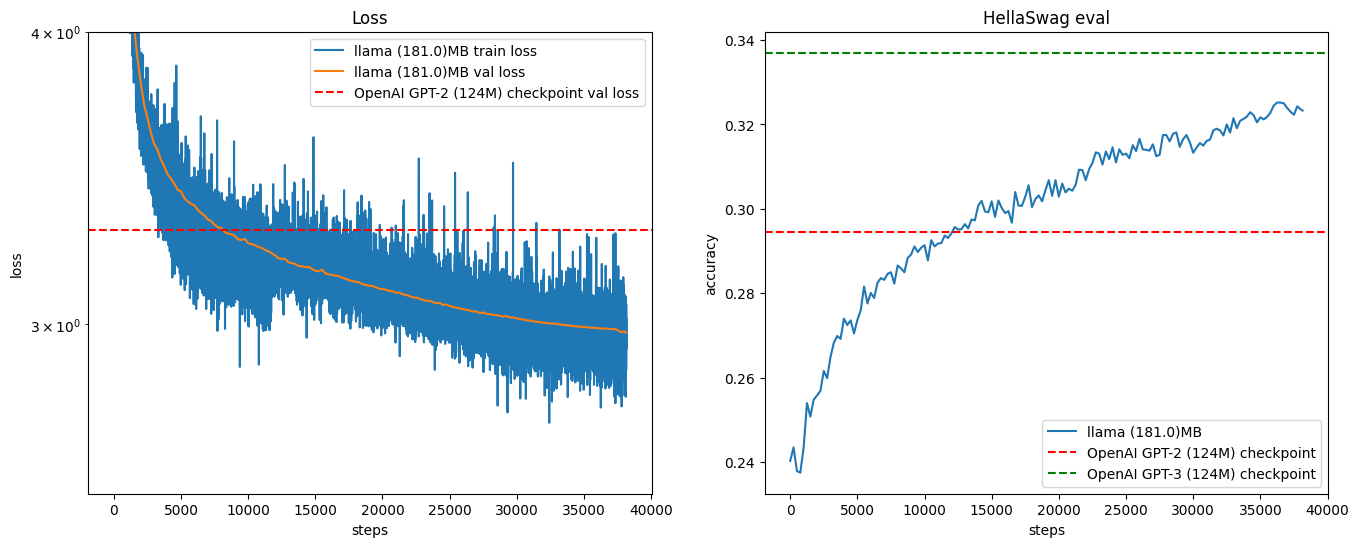

In [17]:
#181095168
model_args = ModelArgs(n_layers=12, n_heads=12, n_kv_heads=4, dim=768, vocab_size=50304, max_seq_len=1024, intermediate_size=4*768)

# load the log file
with open(f"log_{model_args.n_layers}_{model_args.n_heads}_{model_args.n_kv_heads}_6e-4/log.txt", "r") as f:
    lines = f.readlines()
%matplotlib inline
plot_result(lines, 181095168//1e6)


Min Train Loss: 2.712552
Min Validation Loss: 2.9682
Max Hellaswag eval: 0.3267


/var/folders/2z/20dr9wxd40b15f19czgb8fz00000gn/T/ipykernel_3979/3405672249.py:58: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 4.0)


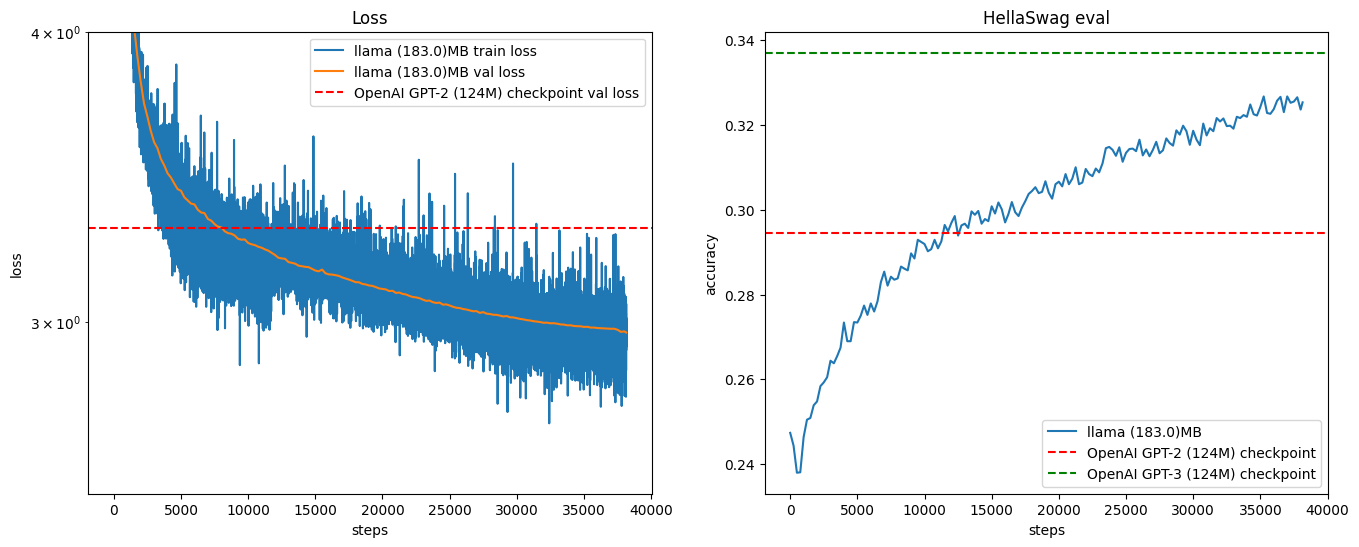

In [18]:
#183454464
model_args = ModelArgs(n_layers=12, n_heads=12, n_kv_heads=6, dim=768, vocab_size=50304, max_seq_len=1024, intermediate_size=4*768)

# load the log file
with open(f"log_{model_args.n_layers}_{model_args.n_heads}_{model_args.n_kv_heads}_6e-4/log.txt", "r") as f:
    lines = f.readlines()
%matplotlib inline
plot_result(lines, 183454464//1e6)

Min Train Loss: 2.696985
Min Validation Loss: 2.9555
Max Hellaswag eval: 0.3305


/var/folders/2z/20dr9wxd40b15f19czgb8fz00000gn/T/ipykernel_3979/3405672249.py:58: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 4.0)


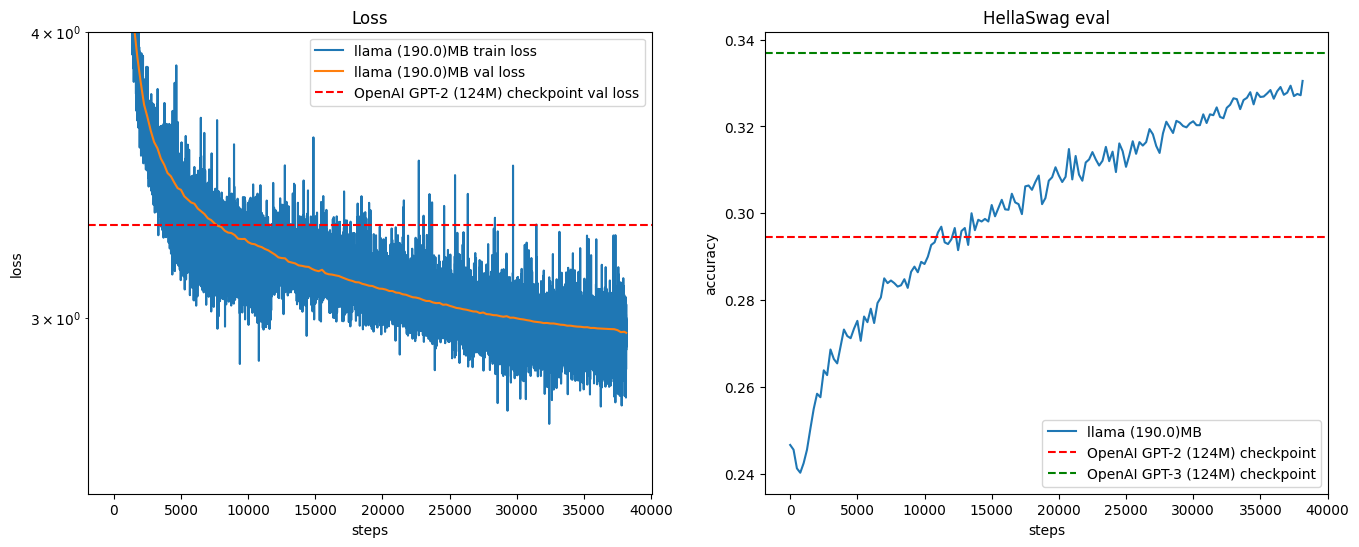

In [19]:
#190532352
model_args = ModelArgs(n_layers=12, n_heads=12, n_kv_heads=12, dim=768, vocab_size=50304, max_seq_len=1024, intermediate_size=4*768)

# load the log file
with open(f"log_{model_args.n_layers}_{model_args.n_heads}_{model_args.n_kv_heads}_6e-4/log.txt", "r") as f:
    lines = f.readlines()
%matplotlib inline
plot_result(lines, 190532352//1e6)

Min Train Loss: 2.648356
Min Validation Loss: 2.9156
Max Hellaswag eval: 0.3429


/var/folders/2z/20dr9wxd40b15f19czgb8fz00000gn/T/ipykernel_3979/3405672249.py:58: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 4.0)


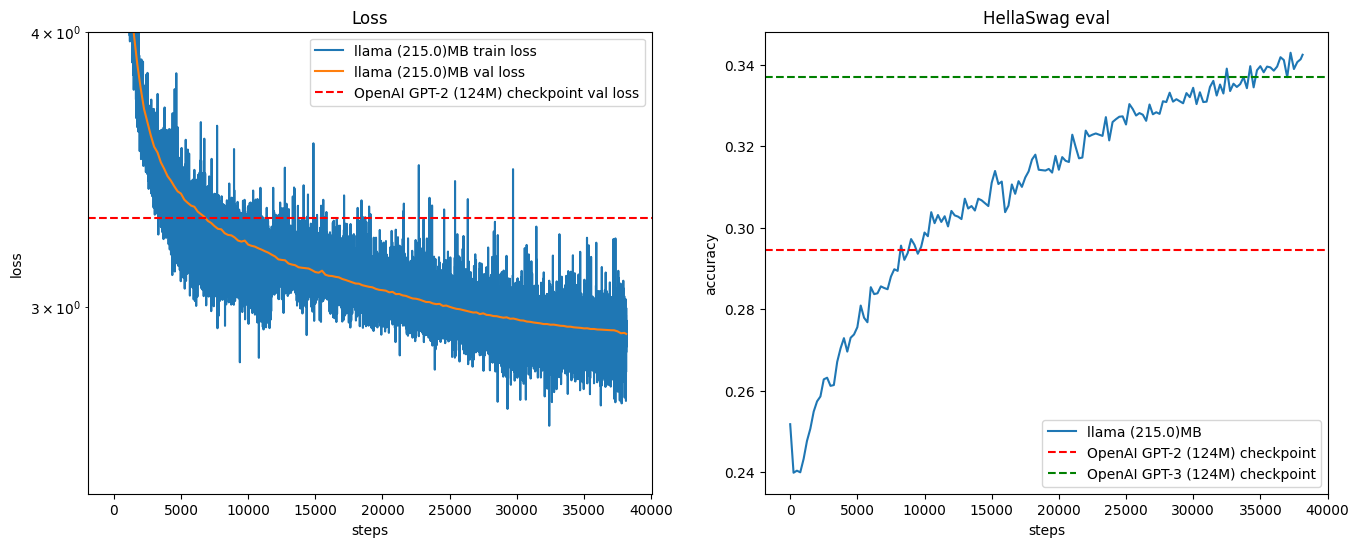

In [20]:
#215704320
model_args = ModelArgs(n_layers=16, n_heads=12, n_kv_heads=4, dim=768, vocab_size=50304, max_seq_len=1024, intermediate_size=4*768)

# load the log file
with open(f"log_{model_args.n_layers}_{model_args.n_heads}_{model_args.n_kv_heads}_6e-4/log.txt", "r") as f:
    lines = f.readlines()
%matplotlib inline
plot_result(lines, 215704320//1e6)

Min Train Loss: 2.645315
Min Validation Loss: 2.9128
Max Hellaswag eval: 0.3411


/var/folders/2z/20dr9wxd40b15f19czgb8fz00000gn/T/ipykernel_3979/3405672249.py:58: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 4.0)


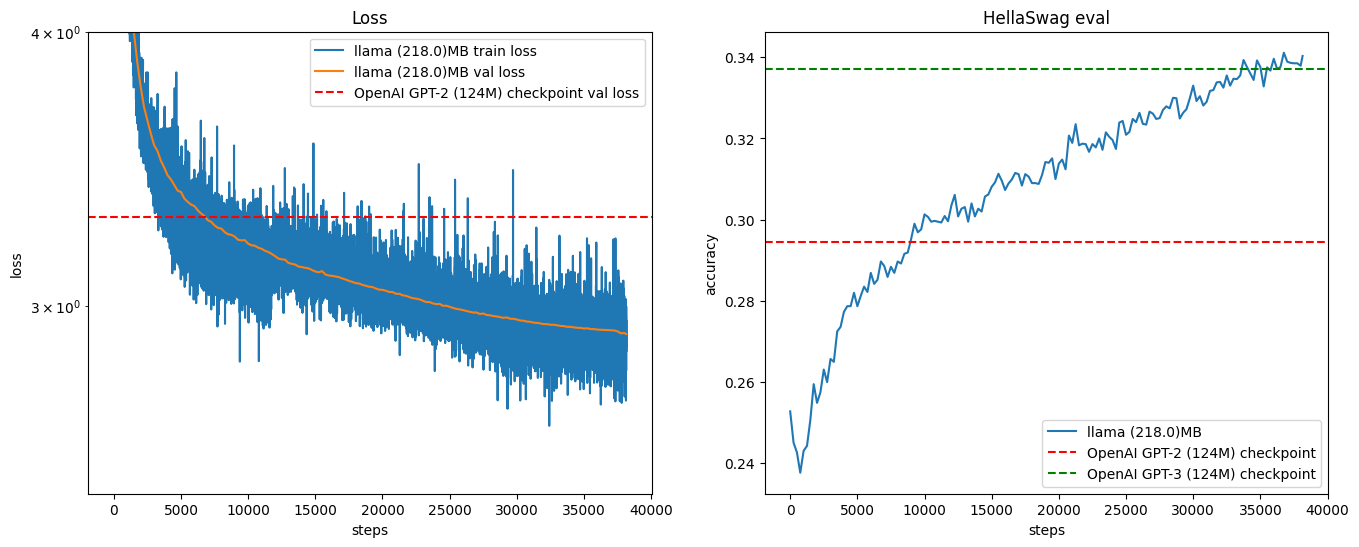

In [21]:
#218850048
model_args = ModelArgs(n_layers=16, n_heads=12, n_kv_heads=6, dim=768, vocab_size=50304, max_seq_len=1024, intermediate_size=4*768)

# load the log file
with open(f"log_{model_args.n_layers}_{model_args.n_heads}_{model_args.n_kv_heads}_6e-4/log.txt", "r") as f:
    lines = f.readlines()
%matplotlib inline
plot_result(lines, 218850048//1e6)

Min Train Loss: 2.724772
Min Validation Loss: 2.9802
Max Hellaswag eval: 0.3315


/var/folders/2z/20dr9wxd40b15f19czgb8fz00000gn/T/ipykernel_3979/3405672249.py:58: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 4.0)


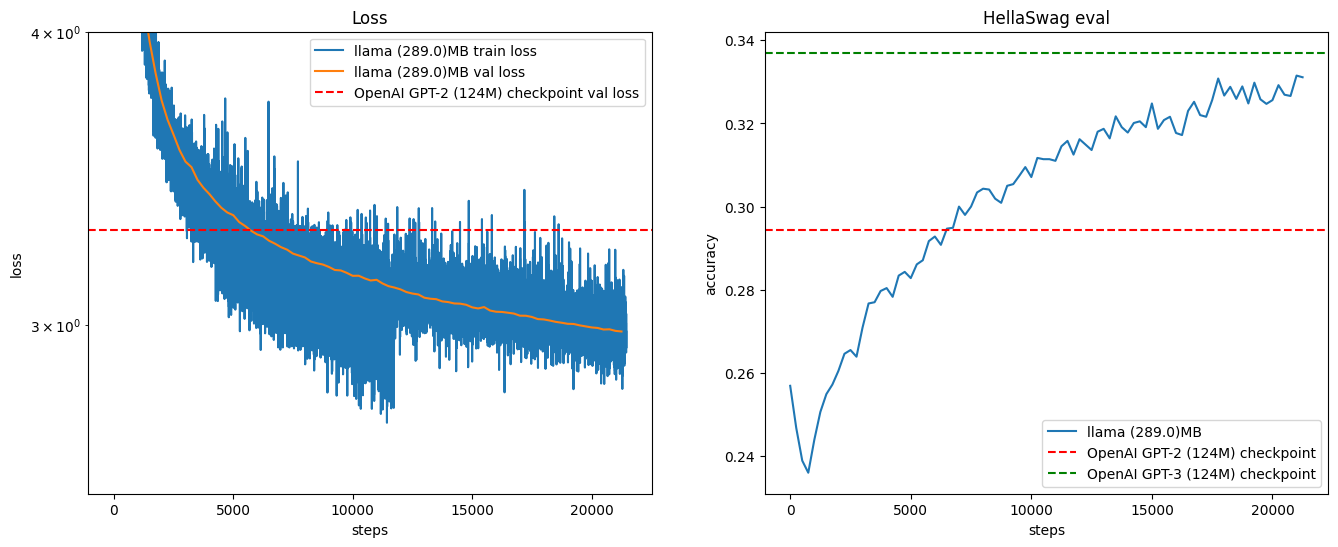

In [23]:
#289641216
model_args = ModelArgs(n_layers=24, n_heads=12, n_kv_heads=6, dim=768, vocab_size=50304, max_seq_len=1024, intermediate_size=4*768)

# load the log file
with open(f"log_{model_args.n_layers}_{model_args.n_heads}_{model_args.n_kv_heads}_6e-04/log.txt", "r") as f:
    lines = f.readlines()
%matplotlib inline
plot_result(lines, 289641216//1e6)

Min Train Loss: 2.622125
Min Validation Loss: 2.8815
Max Hellaswag eval: 0.3473


/var/folders/2z/20dr9wxd40b15f19czgb8fz00000gn/T/ipykernel_16499/3405672249.py:58: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 4.0)


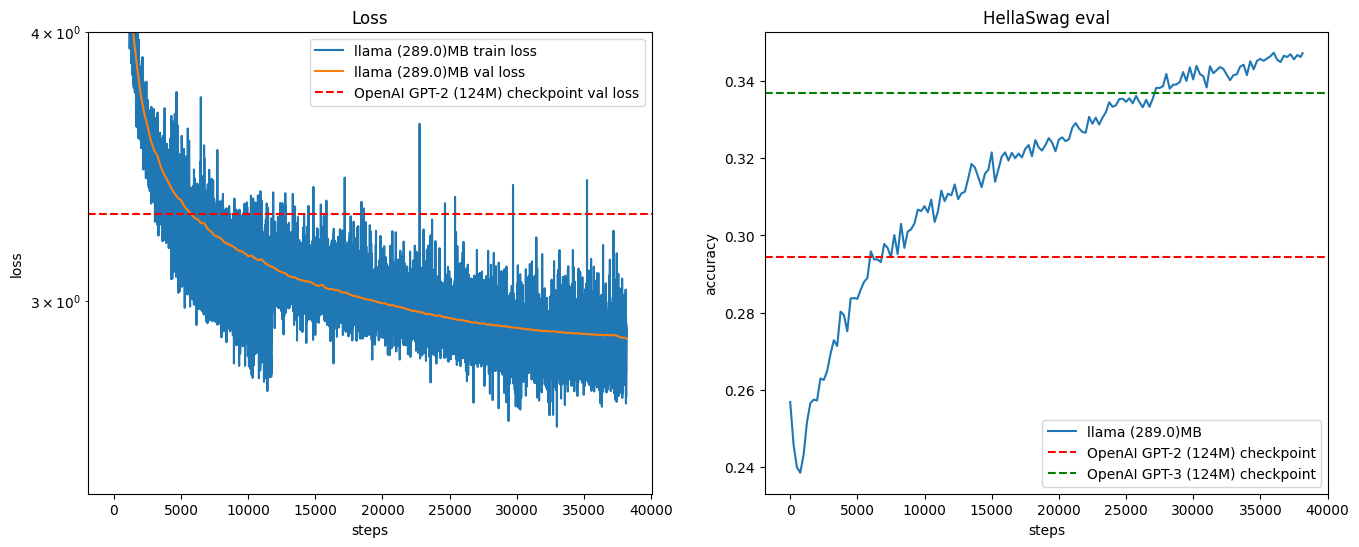

In [5]:
#289641216
model_args = ModelArgs(n_layers=24, n_heads=12, n_kv_heads=6, dim=768, vocab_size=50304, max_seq_len=1024, intermediate_size=4*768)

# load the log file
with open(f"log_{model_args.n_layers}_{model_args.n_heads}_{model_args.n_kv_heads}_6e-04/log.txt", "r") as f:
    lines = f.readlines()
%matplotlib inline
plot_result(lines, 289641216//1e6)

Min Train Loss: 2.596486
Min Validation Loss: 2.8793
Max Hellaswag eval: 0.3512


/var/folders/2z/20dr9wxd40b15f19czgb8fz00000gn/T/ipykernel_3979/3405672249.py:58: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 4.0)


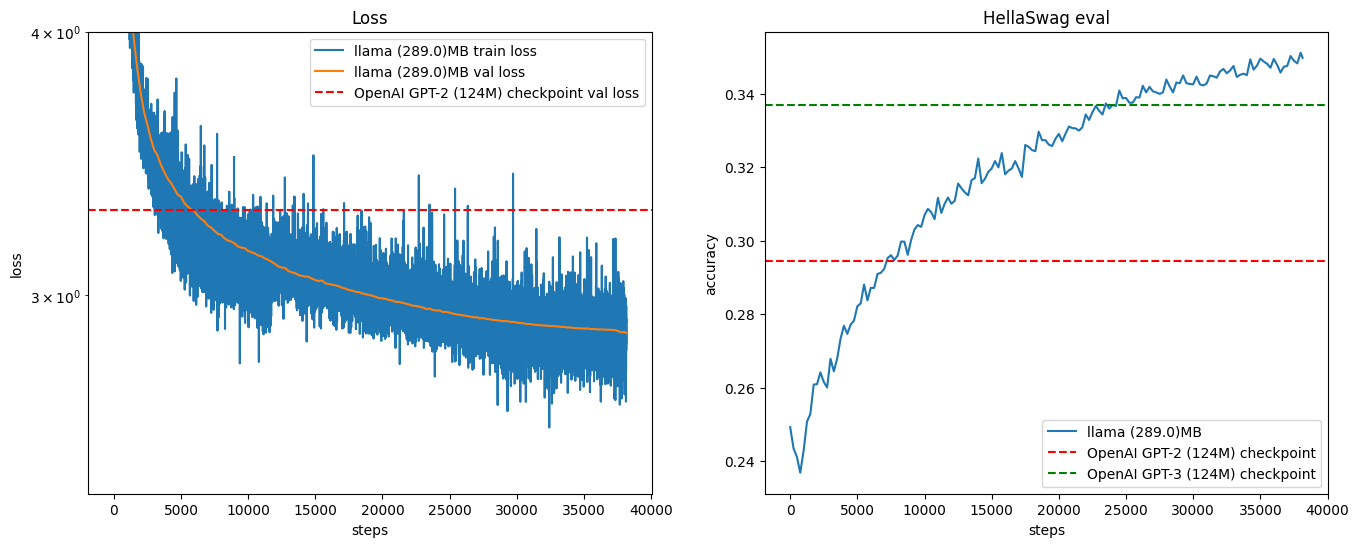

In [24]:
#289641216
model_args = ModelArgs(n_layers=24, n_heads=16, n_kv_heads=8, dim=768, vocab_size=50304, max_seq_len=1024, intermediate_size=4*768)

# load the log file
with open(f"log_{model_args.n_layers}_{model_args.n_heads}_{model_args.n_kv_heads}_6e-04/log.txt", "r") as f:
    lines = f.readlines()
%matplotlib inline
plot_result(lines, 289641216//1e6)

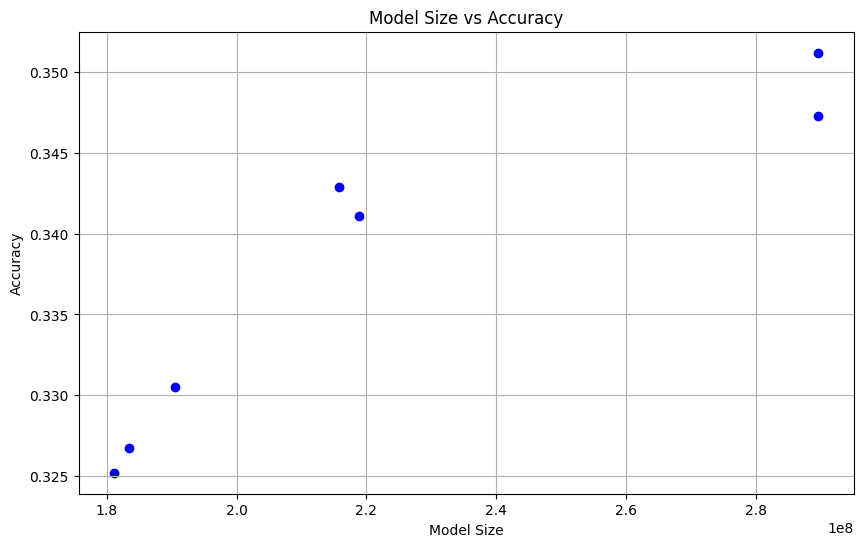

In [6]:
import matplotlib.pyplot as plt

size = [181095168, 183454464, 190532352, 218850048, 215704320, 289641216, 289641216]
acc = [0.3252, 0.3267, 0.3305, 0.3411, 0.3429, 0.3512, 0.3473]
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(size, acc, color='blue')
plt.title('Model Size vs Accuracy')
plt.xlabel('Model Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()